In [1]:
import glob
import cv2
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

__fcall 함수 설명__   
파일명을 받아서, 해당 이미지파일을 연다.   
cv2.cvtColor 명령으로 이미지파일을 gray sclae로 변환한다(이미 binary 처리된 이미지라면 불필요한 부분임)   
cv2.threshold 명령으로 gray scale 이미지를 binary 이미지로 변환한다.(이미 binary 처리된 이미지라면 불필요)   
* cv2.threshold 명령의 파라미터 선정 시 주의할것. 기본적으로 외측배경은 흑백(즉 0)이 되어야 한다.   
* 외측배경이 백색이라면 cv2.THRESH_BINARY_INV 를 사용할 것   
* 외측배경이 흑색이라면 cv2.THRESH_BINARY 를 사용할 것   
참조: https://docs.opencv.org/master/d7/d4d/tutorial_py_thresholding.html

In [2]:
def fcall(img_nm):
    
    #대상 이미지 파일의 확장자를 확인할 것.
    filename = img_nm+'.png'

    # Load the image and convert it to grayscale:
    image = cv2.imread(filename)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    #cv2.THRESH_BINARY 인지 cv2.THRESH_BINARY_INV 꼭 확인할것!
    ret, thresh = cv2.threshold(gray_image, 50, 255, cv2.THRESH_BINARY_INV)
    
    return thresh

__find_a_contour 함수 설명__     
* cv2.findContours 명령으로 binary이미지에서 경계면을 찾는다.    
* cv2.findContours 명령은 대상 이미지에서 찾아지는 모든 경계면을 찾는다. 즉 이미지 상태가 좋지 않으면 의도치 않은 다수의 경계면까지 찾아진다.
* 다수의 경계면이 찾아진 경우, 경계면의 길이가 가장 긴 것이 찾고자 하는 입자의 경계면일 것이다. 찾은 경계면의 좌표정보를 contour_array 에 저장하였다.   
* contour_array에 저장된 좌표를 Fourier descriptor 처리를 위한 다각형 좌표군의 형식으로 변환하였다.

In [3]:
def find_a_contour(thresh):
    contours, hierarchy = cv2.findContours(
        thresh, 
        cv2.RETR_EXTERNAL, 
        cv2.CHAIN_APPROX_NONE)
    ncnt = len(contours[:]) #ncnt = number of contour lines
    chk = 0 #chk은 w번째 경계면을 이루는 좌표의 갯수이다
    set = 0 #set이 내가 찾고 싶은 경계면의 번호이다
    for w in range(ncnt):
       if chk < len(contours[w]):
            chk = len(contours[w])
            set = w
    # 찾은 contour 좌표를 contour_array에 저장한다
    contour_array=contours[set][:,0,:]

    # 폐합된(closed) 다각형(polygon) 좌표군을 생성한다.
    polyg = np.append(contour_array, contour_array[0,:].reshape(1,2), axis=0)
    
    # Equivalent diameter를 구한다.
    area = cv2.contourArea(contours[set])
    equi_diameter = np.sqrt(4*area/np.pi)    
    
    return contour_array, polyg, equi_diameter


__find_eqdpt 함수 설명__    
* 입력받은 폐합된 다각형 좌표군 polyg를 이용하여 FD을 하기 위해 필요한 기본적인 정보를 추출한다.   
* polyg의 좌표 간격은 등간격이 아니므로, Segment 간격이 일정하도록 조정한다.   
* 일정한 간격으로 조정된 좌표군을 eqdpt 변수에 저장한다.
* eqdpt = equal distance points를 줄여서 변수명 설정.   
* 주의! numOfSegments 변수값은 Fourier Descriptor의 갯수가 된다.   

In [4]:
def find_eqdpt(polyg, numOfSegments):

    #Find Contour Perimeter
    perimeter = cv2.arcLength(polyg,True)

    #Find Segment length
    SegLength = perimeter/numOfSegments

    lastpt = polyg[0:1] #제일 첫 point를 last point로 설정
    eqdpt  = polyg[0:1]
    polyIdx = 0
    lenToGo = SegLength

    while len(eqdpt)<numOfSegments:
        lenOnPolyline = np.linalg.norm(polyg[polyIdx+1]-lastpt)
        if lenOnPolyline > lenToGo:
            unitv = polyg[polyIdx+1]-lastpt
            unitv = unitv / np.linalg.norm(unitv)       
            lastpt = unitv*lenToGo + lastpt
            eqdpt = np.append(eqdpt,lastpt.reshape(1,2),axis=0)
            lenToGo = SegLength
        else:
            lenToGo = lenToGo - lenOnPolyline
            polyIdx += 1
            lastpt = polyg[polyIdx]    
    
    return eqdpt

__trans_eqdpt 함수 설명__    
* eqdpt의 등간격 절점군으로 만들어진 폐합 다각형 좌표군 eqdpt에서 도심(centroid)의 좌표를 찾는다.   
* 좌표군의 도심이 원점(0,0)이 되도록 이동시킨다.   
* 이동시킨 좌표군은 3종이다: eqdpt, polyg, contour_array   

In [5]:
def trans_eqdpt(eqdpt, polyg, contour_array):
    # Find Centroid
    M = cv2.moments(contour_array)
    cX = int(M["m10"]/M["m00"])
    cY = int(M["m01"]/M["m00"])

    # Translate Contour points
    centroid = np.empty(contour_array.shape)
    centroid[:,0] = cX
    centroid[:,1] = cY
    contour_array = contour_array - centroid

    centroid = np.empty(polyg.shape)
    centroid[:,0] = cX
    centroid[:,1] = cY
    polyg = polyg - centroid
        
    centroid = np.empty(eqdpt.shape)
    centroid[:,0] = cX
    centroid[:,1] = cY
    
    eqdpt = eqdpt - centroid
    
    return eqdpt, polyg, contour_array

__find_FD 함수 설명__   
* eqdpt 좌표군의 2차원 좌표를 복소수(complex)형태로 변환시킨다.   
* 복소수로 표현된 좌표군 자료에 대해 FFT(Fast Fourier Transformation) 작업을 실시한다.   
* FFT 작업은 np.fft.fft() 함수를 사용하였다.  
참조: https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html   
참조: https://ballentain.tistory.com/3   
참조: github에서 관련 포스트가 있음.   

* np.fft.fftshift() 함수를 사용하여 Zero-frequency에 해당하는 amplitude를 중앙으로 위치시킨다.
참조: https://numpy.org/doc/stable/reference/generated/numpy.fft.fftshift.html#numpy.fft.fftshift   

* 주의! sig_num 변수의 값이 Zero-freq 중앙값을 기준으로 좌우 몇개의 Fourier Descriptors를 추출할 것인지 정한다.  
참조@깃허브: https://github.com/timfeirg/Fourier-Descriptors   

In [6]:
def find_FD(eqdpt,sig_num):

    # 푸리에 변환에 사용할 절점 g의 갯수 = M
    M = len(eqdpt)    
    
    #2차원 Fourier 변환을 위한 준비(복소수형태로 좌표를 변환시킴) --> fft 변환 --> fourier_result에 coef값 저장
    eqdpt_complex = np.empty(eqdpt.shape[:-1],dtype=complex)
    eqdpt_complex.real = eqdpt[:,0]
    eqdpt_complex.imag = eqdpt[:,1]

    fft_result = np.fft.fft(eqdpt_complex)  # np.fft.fft로 구한 coef값은 1/M되지 않았다.
    fft_result = fft_result/M  # 1/M로 나눠주었다.
    fftshifted = np.fft.fftshift(fft_result)  # fftshift가 zero-freq를 중앙으로 위치시킨다.
    
    #sig_num 가 몇개를 추출할지 결정 (pair의 갯수임)
    if (len(fftshifted) % 2) == 0:
        center_index = len(fftshifted)/2
    else:
        center_index = (len(fftshifted)+1)/2
    start = np.int(center_index - sig_num)
    end   = np.int(center_index + sig_num) +1

    #print('center,start,end=',center_index,start,end)
    
    G = fftshifted[start:end]  #start와 end 사이의 중앙값이 가장 큰 coef를 가진다.
    
    # Calculate Magnitude of Fourier Descriptor Coefficients
    G_real = G.real
    G_imag = G.imag
    G_mag  = np.sqrt(G_real**2+G_imag**2)
    
    return G_mag, G_real, G_imag, fft_result, fftshifted

__하나의 입자 이미지에 대해서 앞서 정리한 함수들을 순서대로 실행시킨다__   
__FD를 분석하고, 그 결과를 df1, df2, df3에 담아서 내보낸다__   

In [7]:
def dcfft(img_nm,numOfseg,sig_num):

    thresh = fcall(img_nm)
    
    #입자 이미지의 경계면 좌표를 찾는다.
    contour_array, polyg, eqdia = find_a_contour(thresh)
    
    #앞서 얻은 경계면 좌표 간격은 일정하지 않다. 이를 일정한 간격이 되도록 좌표를 다시 찾는다.
    #numOfSegments = by input param   #등간격 세그먼트의 숫자를 지정한다. 2^n 으로 지정
    eqdpt = find_eqdpt(polyg, numOfseg)
    
    #좌표군들의 도심이 원점이 되도록 이동(translation)시킨다.
    eqdpt, polyg, contour_array = trans_eqdpt(eqdpt, polyg, contour_array)

    #FFT를 실시하여 Fourier Descriptor를 찾는다.
    #sig_num = by input param         #중심을 기준으로 추출할 FD의 갯수를 정한다.
    idx = pd.DataFrame({'idx':np.arange(-sig_num,sig_num+1)})
    
    a,b,c,d,e = find_FD(eqdpt,sig_num)
    
    df1 = pd.DataFrame({'mag':a,'real':b,'imag':c})
    df2 = pd.DataFrame({'fft_result':d,'fftshift_result':e})
    df3 = pd.DataFrame({'x0':eqdpt[:,0],'y0':eqdpt[:,1]})
    
    return df1, df2, df3, eqdia

In [8]:
def fdrecon(title,N,sig_num,real,imag):   #Fourier Descriptor를 이용하여 그림을 새롭게 그리기(reconstruction)
    
    x1 = []
    y1 = []
    
    for k in np.arange(0,N,1):
        t = k/N
        x = 0
        y = 0

        for m in np.arange(-sig_num,sig_num+1):
            phi = 2 * np.pi * m * t
        
            A = real.loc[m,title]
            B = imag.loc[m,title]
        
            x += A*np.cos(phi)-B*np.sin(phi)
            y += A*np.sin(phi)+B*np.cos(phi)
    
        x1.append(x)
        y1.append(y)
    
    df = pd.DataFrame({'x1':x1,'y1':y1})
    
    return df    

__일괄처리 명령어 부분이다__
* 디렉토리 내에 있는 입자 이미지 파일들을 읽어들여서 Fourier descriptor 처리를 진행한다.
* 주의! 이미지 배경이 흑백인지 흰색인지 확인할것! --> fcall 함수 내용 확인
* 주의! 확장자가 jpg인지 png인지 확인할 것! --> fcall 함수 내용 확인

In [9]:
numOfseg = 128   #[중요] 등간격 세그먼트의 숫자를 지정한다. 2^n 으로 지정
sig_num = 40      #[중요] Zero-Freq 중심을 기준으로 아래 위로 추출할 FD의 갯수를 정한다. (Pair의 숫자임)

In [11]:
mylist = [f for f in sorted(glob.glob("*.png"))]  #읽어들일 파일의 확장자 확인할것

mag = pd.DataFrame({'idx':np.arange(-sig_num,sig_num+1)})
real = mag
imag = mag

x0 = pd.DataFrame()
y0 = pd.DataFrame()
eqdia = pd.DataFrame()

for img_nm in mylist[:]:
    print(img_nm[:-4])
    title = img_nm[:-4]
    df1,df2,df3,eqd = dcfft(title,numOfseg,sig_num)
    mag  = pd.concat([mag, df1['mag']],axis=1)
    real = pd.concat([real,df1['real']],axis=1)
    imag = pd.concat([imag,df1['imag']],axis=1)
    x0 = pd.concat([x0,df3['x0']],axis=1)
    y0 = pd.concat([y0,df3['y0']],axis=1)
    d = pd.DataFrame([eqd])
    eqdia = pd.concat([eqdia,d],axis=1)    
    
mag = mag.set_index('idx')    
real = real.set_index('idx')
imag = imag.set_index('idx')

mag.columns = mylist
real.columns = mylist
imag.columns = mylist
x0.columns = mylist
y0.columns = mylist
eqdia.columns = mylist

[10]_re
[1]_re
[4]_re
[5]_re


C:\Users\cysdh\AppData\Local\Temp\ipykernel_20040\4239750735.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  start = np.int(center_index - sig_num)
C:\Users\cysdh\AppData\Local\Temp\ipykernel_20040\4239750735.py:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release

[6]_re
[7]_re
[8]_re
[9]_re


C:\Users\cysdh\AppData\Local\Temp\ipykernel_20040\4239750735.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  start = np.int(center_index - sig_num)
C:\Users\cysdh\AppData\Local\Temp\ipykernel_20040\4239750735.py:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release

Harmonic 1의 절대값은 2D 형상에 대한 Equivalent Circle의 반지름(radius)가 된다.   
각 이미지파일에 대한 Radius(G1)를 구하고, 이값을 list로 변환한 후, Err의 기술통계량값을 G1으로 나눴다.   
Pandas의 DataFrame을 list로 변환하는 것에 대한 정보는 아래의 링크에 있다.   
https://stackoverflow.com/questions/22341271/get-list-from-pandas-dataframe-column-or-row

In [12]:
N = numOfseg #<-- 새로 재구성할 윤곽선 점의 갯수. Error 측정하려면 N = numOfseg로 맞춰야 한다.

er = pd.DataFrame()

for img_nm in mylist[:]:
    x00 = x0.loc[:,img_nm]
    y00 = y0.loc[:,img_nm]
    R = eqdia.loc[0,img_nm]
    
    print(img_nm,R,'Equi_Dia')
    
    obj1 = []
    Mp_range = np.arange(6,21) 
    for Mp in Mp_range:
        dfxy1 = fdrecon(img_nm,N,Mp,real,imag)
        x1 = dfxy1.loc[:,'x1']
        y1 = dfxy1.loc[:,'y1']
        Error = np.sqrt((x00-x1)**2+(y00-y1)**2)
        #MeanErr = Error.describe()['75%']/R
        MeanErr = Error.max()/R
        obj1.append(MeanErr)

    obj2 = pd.Series(obj1,index=Mp_range)
    er = pd.concat([er,obj2],axis=1)

        
er.columns = mylist        
 


[10]_re.png 899.6589813993234 Equi_Dia
[1]_re.png 969.1650571119475 Equi_Dia
[4]_re.png 1200.8952546325788 Equi_Dia
[5]_re.png 897.366899815928 Equi_Dia
[6]_re.png 1143.1614298202553 Equi_Dia
[7]_re.png 1030.8239314029527 Equi_Dia
[8]_re.png 948.1490895711343 Equi_Dia
[9]_re.png 1425.6500323847686 Equi_Dia


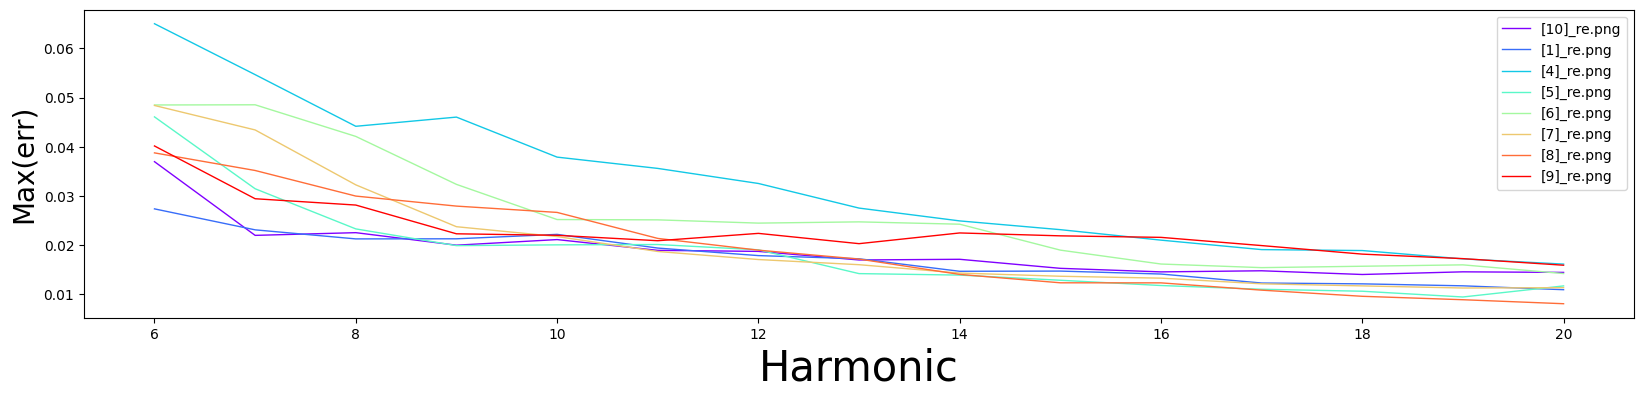

In [13]:
fig = plt.figure(figsize=(20, 4)) 
ax1 = plt.subplot()
color=iter(cm.rainbow(np.linspace(0,1,len(mylist[:]))))

for a in mylist[:]:
    X1 = Mp_range
    Y1 = er[a].values

    c = next(color)
    ax1.plot(X1,Y1,linewidth=1.0,c=c,linestyle='-',label=a)

    ax1.legend()

plt.xlabel('Harmonic',fontsize=30)
plt.ylabel('Max(err)',fontsize=20)
plt.grid(False)